# Dowload Planet Data from Google Earth Engine (GEE) from Python

Downloading Planet imagery from Google Earth Engine (GEE) using a Planet personal account. To work with this notebook you will need to connect your GEE account to your Planet personal account in order to have the appropiate download permissions. For this example, we will use the data collection from Planet and the Norway's International Climate and Forests Initiative (NICFI) satellite data program.

Date Modified: 10/05/2023  
Author: Jordan A. Caraballo-Vega

In [1]:
# uncomment this line if you need to install any of these packages
# !pip install ee geedim rioxarray shapely geopandas geemap datasets leafmap localtileserver

## Import libraries

Here we import general Python libraries. The most important library from this notebook is geedim. This library
allows us to download Google Earth Engine data directly from Python without having to store data in any intermediate Google Drive or Cloud Storage devices.

In [2]:
import ee
import os
import geemap
import leafmap
import datasets
import geedim as gd
import geopandas as gpd
import rioxarray as rxr

from glob import glob
from pathlib import Path
from ipyleaflet import Map
from shapely.geometry import box
from huggingface_hub import snapshot_download
from localtileserver import get_leaflet_tile_layer, TileClient

## Get default parameters and GEE session

In [3]:
dataset_url: str = 'nasa-cisto-data-science-group/senegal-lcluc-tutorial'
gee_data_collection: str = 'projects/planet-nicfi/assets/basemaps/africa'
grid_filename: str = 'Senegal_Grid.gpkg'

In [4]:
output_dir = 'planet'

Here we create an output directory to store any artifacts out of our data downloads.

In [5]:
os.makedirs(output_dir, exist_ok=True)

## Start GEE Session

In [6]:
try: #authentication only required once for a notebook
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [7]:
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

NASADEM: NASA NASADEM Digital Elevation 30m


## Download Geospatial Data to Work With

In [8]:
senegal_dataset = snapshot_download(repo_id=dataset_url, allow_patterns="*.gpkg", repo_type='dataset')
grid_filename = os.path.join(senegal_dataset, grid_filename)
print(f'Downloaded {grid_filename} filename.')

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Downloaded /Users/jacaraba/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--senegal-lcluc-tutorial/snapshots/dc063d6c88640f147a9d1403222f434cd2710a92/Senegal_Grid.gpkg filename.


## Get shape for downloading the Planet data

In [9]:
grid_gdf = gpd.read_file(grid_filename)
grid_gdf.head()

,h,v,tile,geometry
0,0,49,h00v49,"POLYGON ((226973.589 1361757.080, 226973.589 1..."
1,1,49,h01v49,"POLYGON ((236973.589 1361757.080, 236973.589 1..."
2,2,49,h02v49,"POLYGON ((246973.589 1361757.080, 246973.589 1..."
3,3,49,h03v49,"POLYGON ((256973.589 1361757.080, 256973.589 1..."
4,4,49,h04v49,"POLYGON ((266973.589 1361757.080, 266973.589 1..."


<Axes: >

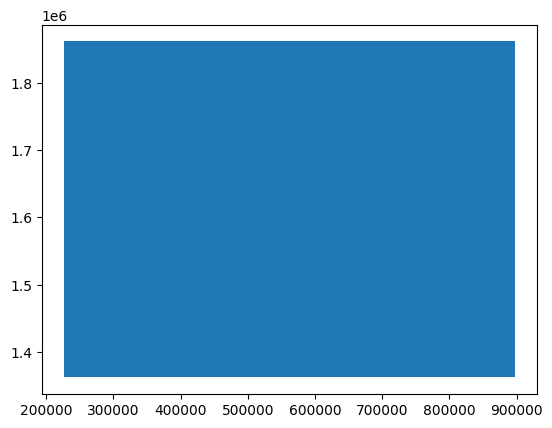

In [10]:
grid_gdf.plot()

In [11]:
grid_gdf.crs

<Projected CRS: EPSG:32628>
Name: WGS 84 / UTM zone 28N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°W and 12°W, northern hemisphere between equator and 84°N, onshore and offshore. Gambia. Greenland. Guinea. Guinea-Bissau. Iceland. Ireland - offshore Porcupine Basin. Mauritania. Morocco. Senegal. Sierra Leone. Western Sahara.
- bounds: (-18.0, 0.0, -12.0, 84.0)
Coordinate Operation:
- name: UTM zone 28N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# tile_id = 'h50v36'
tile_id = 'h37v39'

In [13]:
# select the grid we want to download
download_gdf = grid_gdf[grid_gdf['tile'] == tile_id].reset_index(drop=True)
download_gdf.head()

,h,v,tile,geometry
0,37,39,h37v39,"POLYGON ((596973.589 1461757.080, 596973.589 1..."


In [14]:
xx, yy = download_gdf.to_crs('EPSG:4326').geometry[0].exterior.coords.xy
image_bounds = [[x, y] for x, y in zip(xx, yy)]
region = ee.Geometry.Polygon(image_bounds)

## Lookup and download the data

In [15]:
year = '2023'
month = '01'
output_filename = f'{tile_id}_planet_medres_normalized_analytic_{year}-{month}_mosaic.tif'

In [16]:
# make collection and search, reporting cloudless portions
coll = gd.MaskedCollection.from_name(gee_data_collection)
coll = coll.search(f'{year}-01-01', f'{year}-12-01', region, cloudless_portion=0)
print(coll.schema_table)
print(coll.properties_table)

ABBREV  NAME               DESCRIPTION
------  -----------------  -------------------------------------------
ID      system:id          Earth Engine image id
DATE    system:time_start  Image capture date/time (UTC)
FILL    FILL_PORTION       Portion of region pixels that are valid (%)
ID                                                                                            DATE             FILL
--------------------------------------------------------------------------------------------- ---------------- ----
projects/planet-nicfi/assets/basemaps/africa/planet_medres_normalized_analytic_2023-01_mosaic 2023-01-01 00:00  100
projects/planet-nicfi/assets/basemaps/africa/planet_medres_normalized_analytic_2023-02_mosaic 2023-02-01 00:00  100
projects/planet-nicfi/assets/basemaps/africa/planet_medres_normalized_analytic_2023-03_mosaic 2023-03-01 00:00  100
projects/planet-nicfi/assets/basemaps/africa/planet_medres_normalized_analytic_2023-04_mosaic 2023-04-01 00:00  100
projects/planet-n

In [17]:
# create and download an image
if not os.path.isfile(output_filename):
    im = gd.MaskedImage.from_id(f'{gee_data_collection}/planet_medres_normalized_analytic_{year}-{month}_mosaic')
    im.download(output_filename, region=region, crs='EPSG:32628')

## Visualize the downloaded image(s)

In [18]:
# First, create a tile server from local raster file
client = TileClient(output_filename)

# Create ipyleaflet tile layer from that server
t = get_leaflet_tile_layer(client, band=[3, 2, 1])

m = Map(center=client.center(), zoom=client.default_zoom, scroll_wheel_zoom=True)
m.add_layer(t)
m

Map(center=[13.266114748675804, -14.058646159452731], controls=(ZoomControl(options=['position', 'zoom_in_text…

In [20]:
!ls

Data_DownloadPlanet.ipynb
DownloadPlanet.ipynb
h37v39_planet_medres_normalized_analytic_2023-01_mosaic.tif
planet
